STEP 1: Imports & Global Config

In [24]:
# 1 Imports & Config

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

RANDOM_STATE = 42

STEP 2: Data Ingestion & Validation

In [25]:
# 2 Data Ingestion

def load_data(path):
    dtypes = {
        "store_id": "category",
        "item_id": "category",
        "promo": "int8",
        "weekday": "int8",
        "month": "int8"
    }
    df = pd.read_csv(path, parse_dates=["date"], dtype=dtypes)
    return df

df = load_data("/content/retail_sales.csv")
df.sort_values(["store_id", "item_id", "date"], inplace=True)
df.reset_index(drop=True, inplace=True)

In [26]:
# 2.1 Data Quality Checks

def data_quality_report(df):
    report = {
        "rows": df.shape[0],
        "columns": df.shape[1],
        "missing_values": df.isnull().sum().sum(),
        "duplicates": df.duplicated().sum(),
        "date_range": (df["date"].min(), df["date"].max())
    }
    return report

data_quality_report(df)

{'rows': 4565000,
 'columns': 8,
 'missing_values': np.int64(0),
 'duplicates': np.int64(0),
 'date_range': (Timestamp('2019-01-01 00:00:00'),
  Timestamp('2023-12-31 00:00:00'))}

STEP 3: EDA

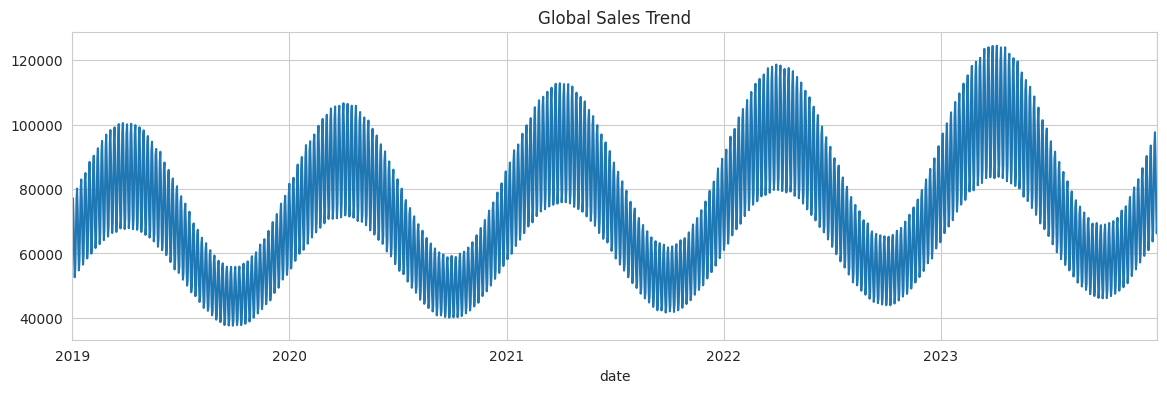

In [27]:
# 3 EDA

def plot_sales_trend(df):
    daily = df.groupby("date")["sales"].sum()
    plt.figure(figsize=(14,4))
    daily.plot()
    plt.title("Global Sales Trend")
    plt.show()

plot_sales_trend(df)

STEP 4: Feature Engineering

In [28]:
# 4 Feature Engineering

def add_lag_features(df, lags):
    for lag in lags:
        df[f"sales_lag_{lag}"] = (
            df.groupby(["store_id","item_id"])["sales"]
              .shift(lag)
        )
    return df

def add_rolling_features(df, windows):
    for w in windows:
        df[f"rolling_mean_{w}"] = (
            df.groupby(["store_id","item_id"])["sales"]
              .shift(1)
              .rolling(w)
              .mean()
        )
    return df

df = add_lag_features(df, [1,7,14,28])
df = add_rolling_features(df, [7,14,28])
df.dropna(inplace=True)

STEP 5: Feature Store

In [29]:
# 5 Feature Store Construction

FEATURES = [
    "price", "promo", "weekday", "month",
    "sales_lag_1", "sales_lag_7", "sales_lag_14", "sales_lag_28",
    "rolling_mean_7", "rolling_mean_14", "rolling_mean_28"
]

TARGET = "sales"

STEP 6: BASELINES + ADVANCED MODELS

6.1 Evaluation Utilities

In [30]:
# 6.1 Evaluation Utilities
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def evaluate_model(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"{model_name} Performance")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAPE : {mape:.4f}")

    return {
        "model": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    }

In [31]:
# Train / Test Split

train = df[df["date"] < "2023-01-01"].copy()
test  = df[df["date"] >= "2023-01-01"].copy()

features = FEATURES
target = "sales"

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

print(train.shape, test.shape)

(3582500, 15) (912500, 15)


In [32]:
print("sales_lag_1" in test.columns)

True


6.2 Naive Baseline Model

In [64]:
# 6.2 Naive Baseline Model


def train_naive_model(train_df):
    return None

def predict_naive_model(test_df):
    return test_df["sales_lag_1"]

naive_model = train_naive_model(train)
naive_preds = predict_naive_model(test)

naive_metrics = evaluate_model(
    y_test,
    naive_preds,
    "Naive Baseline"
)

Naive Baseline Performance
MAE  : 6.6916
RMSE : 9.4351
MAPE : 4061876705014.9404


STEP 6.3: Moving Average Baseline Model

In [46]:
# Train Function

def train_moving_average(train_df, window=7):
    """
    Moving Average baseline does not learn parameters.
    The 'training' step only fixes the window size.
    """
    return window

In [47]:
# Predict Function

def predict_moving_average(df, window=7):
    return (
        df.groupby(["store_id", "item_id"])["sales"]
          .shift(1)
          .rolling(window)
          .mean()
    )

In [58]:
# Identify valid (non-NaN) predictions
valid_idx = ma_preds.notna()

In [59]:
ma_metrics = evaluate_model(
    y_test[valid_idx],
    ma_preds[valid_idx],
    model_name="Moving Average Baseline (7-day)"
)

Moving Average Baseline (7-day) Performance
MAE  : 5.8719
RMSE : 8.0918
MAPE : 4176522559461.1138


In [60]:
# Run + Evaluate

ma_window = train_moving_average(train, window=7)

ma_preds = predict_moving_average(test, ma_window)

valid_idx = ma_preds.notna()

ma_metrics = evaluate_model(
    y_test[valid_idx],
    ma_preds[valid_idx],
    model_name="Moving Average Baseline (7-day)"
)

Moving Average Baseline (7-day) Performance
MAE  : 5.8719
RMSE : 8.0918
MAPE : 4176522559461.1138


STEP 7: ADVANCED ML MODELS

7.1 LightGBM Model

In [61]:
# Train Function
from lightgbm import LGBMRegressor

def train_lgbm(X_train, y_train):
    model = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model

In [52]:
# Predict Function
def predict_lgbm(model, X):
    return model.predict(X)

In [53]:
# Run + Evaluate
lgbm_model = train_lgbm(X_train, y_train)
lgbm_preds = predict_lgbm(lgbm_model, X_test)

lgbm_metrics = evaluate_model(y_test, lgbm_preds, "LightGBM")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.407706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1506
[LightGBM] [Info] Number of data points in the train set: 3582500, number of used features: 11
[LightGBM] [Info] Start training from score 28.523469
LightGBM Performance
MAE  : 2.5717
RMSE : 3.2285
MAPE : 3438561718414.3179


STEP 8: MODEL COMPARISON

In [68]:
results_list = [naive_metrics, ma_metrics, lgbm_metrics]

if "xgb_metrics" in globals():
    results_list.append(xgb_metrics)

results = pd.DataFrame(results_list)
results.sort_values("RMSE")

,model,MAE,RMSE,MAPE
2,LightGBM,2.571677,3.228465,3.438562e+12
1,Moving Average Baseline (7-day),5.871855,8.091789,4.176523e+12
0,Naive Baseline,6.691605,9.435086,4.061877e+12


STEP 9: FEATURE IMPORTANCE

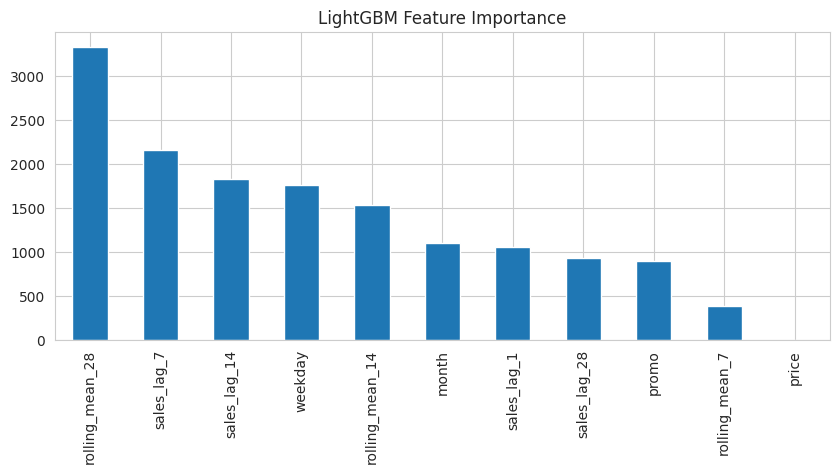

In [69]:
feature_importance = pd.Series(
    lgbm_model.feature_importances_,
    index=FEATURES
).sort_values(ascending=False)

plt.figure(figsize=(10,4))
feature_importance.plot(kind="bar")
plt.title("LightGBM Feature Importance")
plt.show()

STEP 10: ERROR ANALYSIS

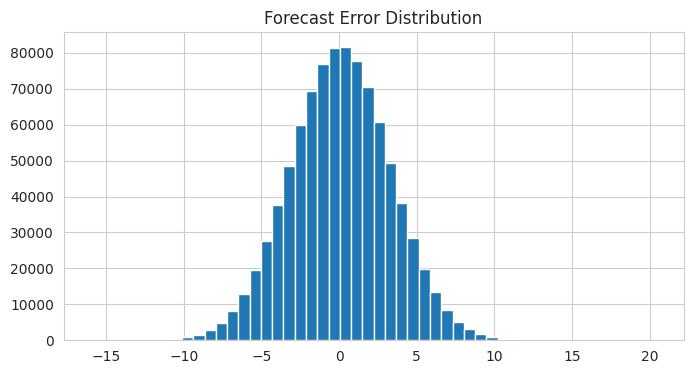

In [70]:
errors = y_test - lgbm_preds

plt.figure(figsize=(8,4))
plt.hist(errors, bins=50)
plt.title("Forecast Error Distribution")
plt.show()

STEP 11: MODEL PERSISTENCE

In [71]:
import joblib

joblib.dump(lgbm_model, "demand_forecast_model.pkl")
print("LightGBM model saved successfully")

LightGBM model saved successfully


STEP 12: INVENTORY OPTIMIZATION

In [72]:
LEAD_TIME = 7
SERVICE_LEVEL_Z = 1.65  # 95% service level

test["forecast"] = lgbm_preds

inventory = (
    test.groupby(["store_id", "item_id"])
    .agg(
        mean_demand=("forecast", "mean"),
        std_demand=("forecast", "std")
    )
)

inventory["safety_stock"] = (
    SERVICE_LEVEL_Z * inventory["std_demand"] * np.sqrt(LEAD_TIME)
)

inventory["reorder_point"] = (
    inventory["mean_demand"] * LEAD_TIME
    + inventory["safety_stock"]
)

STEP 13: SCENARIO SIMULATION

In [73]:
def stockout_probability(demand, rop):
    return (demand > rop).mean()

inventory["stockout_risk"] = inventory.apply(
    lambda row: stockout_probability(test["forecast"], row["reorder_point"]),
    axis=1
)

In [74]:
inventory.head()
inventory.describe()

,mean_demand,std_demand,safety_stock,reorder_point,stockout_risk
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,32.233487,9.331391,40.736089,266.370497,0.000039
std,12.374267,3.570749,15.588067,102.102944,0.000232
min,11.077163,2.890924,12.620299,90.629678,0.000000
25%,21.237723,6.163573,26.907016,176.087734,0.000000
50%,32.190859,9.375188,40.927286,265.268836,0.000000
75%,42.163403,12.241087,53.438338,348.863778,0.000000
max,60.064421,17.745835,77.469258,492.687678,0.003582


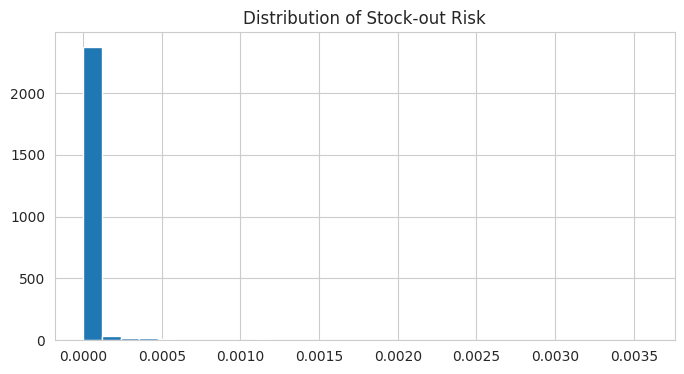

In [75]:
import matplotlib.pyplot as plt

inventory["stockout_risk"].hist(bins=30, figsize=(8,4))
plt.title("Distribution of Stock-out Risk")
plt.show()

In [76]:
for z in [1.28, 1.65, 2.05]:  # 90%, 95%, 98%
    inventory["safety_stock"] = z * inventory["std_demand"] * np.sqrt(LEAD_TIME)
    inventory["reorder_point"] = (
        inventory["mean_demand"] * LEAD_TIME + inventory["safety_stock"]
    )
    print(f"Service level Z={z}, Avg stockout risk:",
          inventory["stockout_risk"].mean())

Service level Z=1.28, Avg stockout risk: 3.930871232876712e-05
Service level Z=1.65, Avg stockout risk: 3.930871232876712e-05
Service level Z=2.05, Avg stockout risk: 3.930871232876712e-05
